In [162]:
using RobustAndOptimalControl
using ControlSystemsBase 
using Plots

In [163]:
function parse_tf_from_file(fname)

    file = open(fname, "r")
    lines = readlines(file)
    close(file)

    # join to one String
    lines = join(lines)
    num = split(lines, "]")[1]
    num = replace(num, "[" => "")

    den = split(lines, "]")[2]
    den = replace(den, "[" => "")
    den = replace(den, "]" => "")


    num_f = []
    for fs in split(num, " ")
        if fs == ""
            continue
        end
        push!(num_f, parse(Float64, fs))
    end

    den_f = []
    for fs in split(den, " ")
        if fs == ""
            continue
        end
        push!(den_f, parse(Float64, fs))
    end

    num_f = Vector{Float64}(num_f)
    den_f = Vector{Float64}(den_f)


    G = tf(num_f, den_f)
    G = minreal(G)
    return G
end

parse_tf_from_file (generic function with 1 method)

# Plant

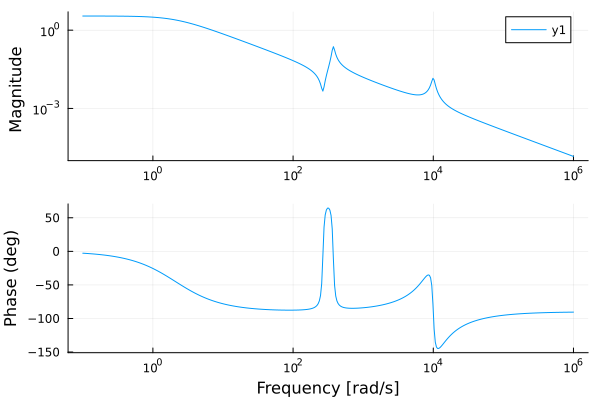

In [164]:
s = tf("s")
G = parse_tf_from_file("tf_txt/Gf.txt")

bodeplot(G)

In [165]:
function pt2(w0,d)
    s = tf("s")
    return w0^2/(s^2 + 2*d*w0*s + w0^2)
end

pt2 (generic function with 1 method)

# Uncertainty

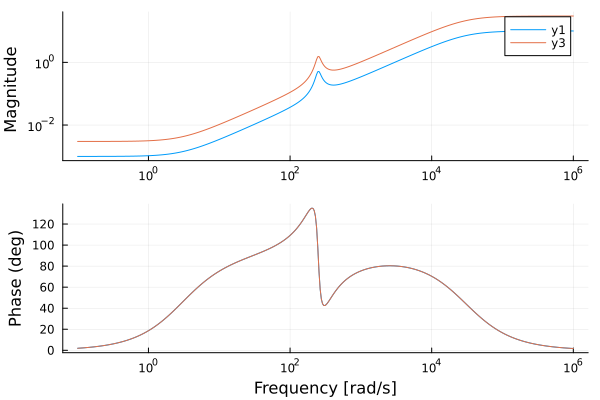

In [166]:

W_delta0 = parse_tf_from_file("tf_txt/W_delta.txt")
W_delta = W_delta0*3
bodeplot([W_delta0,W_delta])


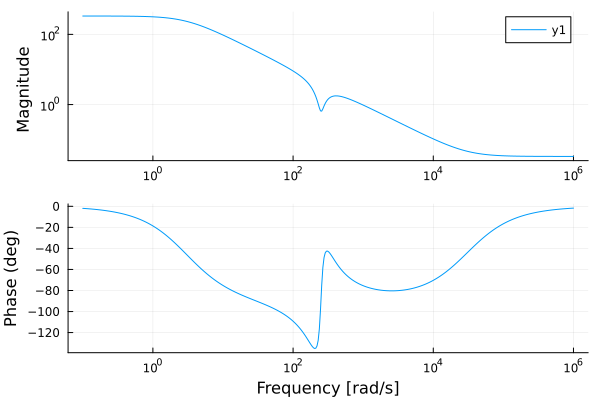

In [167]:
bodeplot(1/W_delta)

# Control limit

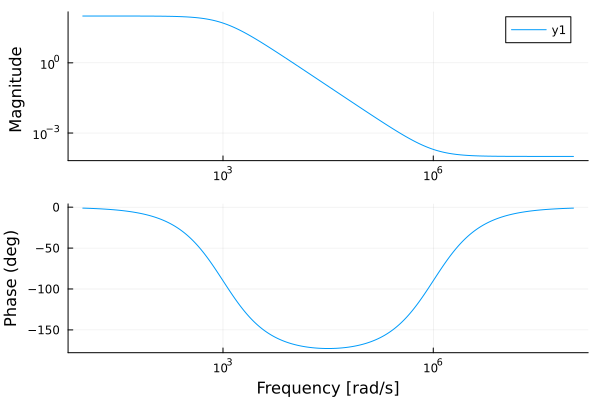

In [168]:

w_lim = 1e3
max_T = 80

WU = pt2(w_lim,1)*100 * 1/pt2(w_lim*1e3,1)

bodeplot(WU)

In [169]:
WU = 1/WU

TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
1.0e12s^2 + 2.0e15s + 1.0e18
----------------------------
1.0e8s^2 + 2.0e14s + 1.0e20

Continuous-time transfer function model

0.1375
165.0
1101.1
1320.0

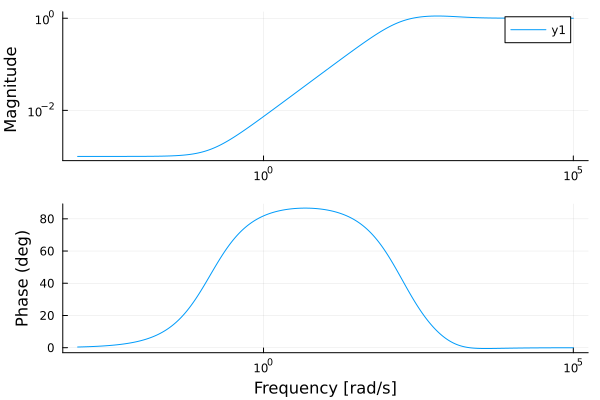

In [170]:
# Desired closed loop bw rad/s
omega_cl = 25*6.6
omega_max = 200*6.6


S_max = 1.2
S_inf = 1.001
S_L = 1e-3


omega_0 = omega_cl/S_max * S_L

omega_r = S_inf/S_max * omega_max

print(omega_0)
print('\n')
print(omega_cl)
print('\n')
print(omega_r)
print('\n')
print(omega_max)


WS = (s/omega_0 + 1)/(s/omega_cl + 1) * (s/omega_max + 1)/(s/omega_r + 1)*S_L 

WS = 1/WS

bodeplot(1/WS)

In [171]:

WT = W_delta

P = hinfpartition(G, WS, WU, WT)
hinfassumptions(P)



All assumtions are satisfied!


true

1.0835234256008013

┌ Warning: Numerical problems encountered, returned γ is adjusted to the γ achieved by the computed controller (γ - γactual = 0.00577644260980148). Try solving the problem in higher precision by calling hinfsynthesize(...; ftype=BigFloat)
└ @ RobustAndOptimalControl C:\Users\Elias\.julia\packages\RobustAndOptimalControl\Qj5nj\src\hinfinity_design.jl:203


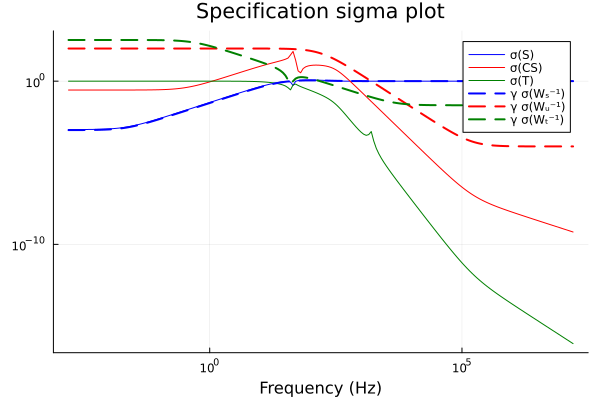

In [172]:
K, y = hinfsynthesize(P, γrel=1.05)
K = minreal(K)
print(y)

Pcl, S, KS, T = hinfsignals(P, G, K)

specificationplot([S,K*S,T], [WS,WU,WT],wint=(-2,8))

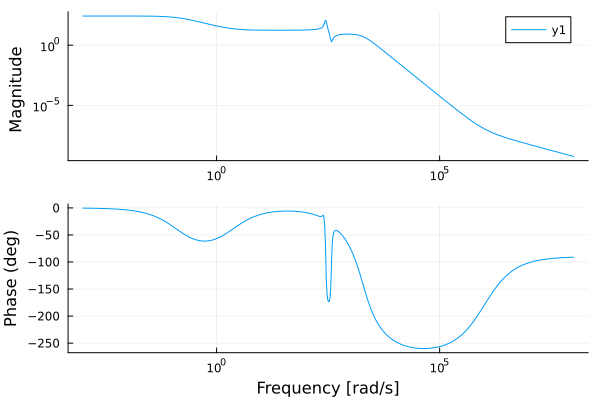

In [173]:
bodeplot(K)

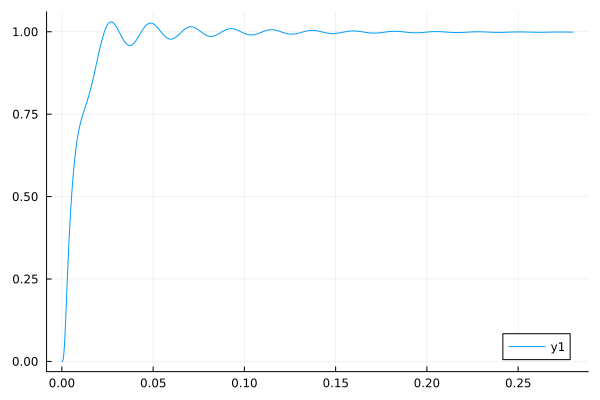

In [174]:
Pcl = G*K/(1 + G*K)

Pcl = minreal(Pcl)
y, t = step(Pcl);
plot(t, y')

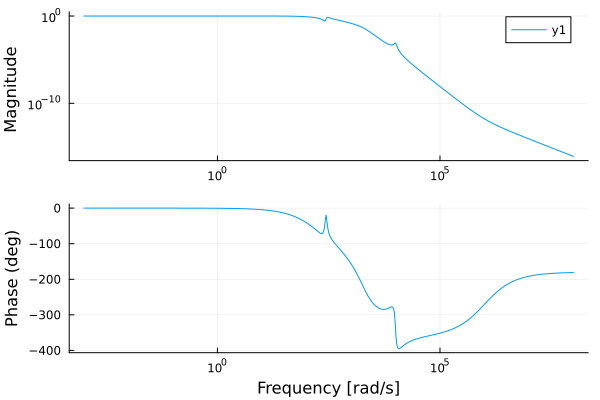

In [175]:



bodeplot(Pcl)

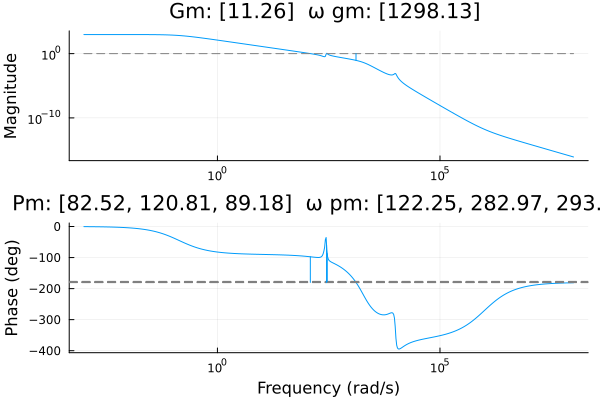

In [176]:
L = minreal(G*K)
marginplot(L)

In [177]:
K = tf(K)

num = K.matrix[1,1].num.coeffs
den = K.matrix[1,1].den.coeffs

fpath = "tf_txt/C_hinf.txt"
open(fpath, "w") do file
    write(file, string(num))
    write(file, "\n")
    write(file, string(den))
end

K

TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
     0.05704456420062343s^11 + 115985.1555557847s^10 + 6.084801180645264e10s^9 + 1.919002323443764e15s^8 + 1.1770596455466828e19s^7 + 1.891652959018094e23s^6 + 3.865431051465647e26s^5 + 6.538608870261385e28s^4 + 7.706399553877255e31s^3 + 4.588322995614797e33s^2 + 3.2470585645575843e36s + 6.791410310118236e36
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1.0s^12 + 37095.56300135222s^11 + 3.350074260644668e8s^10 + 4.3126813923392163e12s^9 + 2.1091369005811228e16s^8 + 5.148185911890515e19s^7 + 7.159785342883218e22s^6 + 4.7305465838272e25s^5 + 1.2005471689249974e28s^4 + 5.788483987313707e30s^3 + 4.99488921511063e32s^2 + 1.8655223043445165e35s + 2.564150326